Read position decoder results (xlsx files, output from `decode_position.py`). Plot decoder error and check the importance index.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
from statannotations.Annotator import Annotator
plt.style.use('figure.mplstyle')

import function.utils as ut

In [20]:
def simple_pair_lines(data, ax, category=['Fam','Nov'], colors=['C0','C1'], width=0.65,
                      pvalue=None, test='t-test_paired'):
    '''
    Simple bar plot (mean and s.e.m.) with paired lines on the given axis.
    Annotate the statistical significance with paired t-test or Wilcoxon signed-rank test.

    Parameters
    ----------
    data : numpy 2D array, shape (n_data, n_catg=2)
    ax : matplotlib axes object
    category : list or tuple
        The category names
    colors : list or tuple
        Color for each category
    width : float 
        The bar width (between 0 and 1)
    pvalue : None or list of float
        If pvalue is provided, annotate the significance without performing the test
    test : str
        Statistical test, paired ('t-test_paired' or 'Wilcoxon')
    '''
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    n_data, n_catg = data.shape  # n_catg should be two
    
    ## Draw paired lines
    for line in data:
        ax.plot(np.arange(n_catg), line, lw=1.2, c='gray', alpha=0.8, zorder=-1)
        
    ## Draw bar plot
    height = np.mean(data, axis=0)
    yerr = stats.sem(data, axis=0)
    for b in range(n_catg):
        ax.bar(b, height[b], yerr=yerr[b], width=width, color='none', linewidth=lwidth, 
               edgecolor=colors[b], ecolor=colors[b], capsize=4,
               error_kw=dict(elinewidth=lwidth, capthick=lwidth))
    
    ## Statistical annotation
    df = pd.DataFrame({'Data': data.ravel(),
                       'Category': list(category)*n_data})
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    annot = Annotator(ax, [category], data=df, x='Category', y='Data', verbose=False)
    if pvalue is None:
        annot.configure(test=test, loc='outside', line_height=0., line_width=lwidth, pvalue_format=pformat)
        annot.apply_and_annotate()
    else:
        annot.configure(test=None, loc='outside', line_height=0., line_width=lwidth, pvalue_format=pformat)
        annot.set_pvalues(pvalue)
        annot.annotate()

In [2]:
# %% Setup
excelfiles = [r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Position decoder enriched.xlsx',
              r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Position decoder dissimilar.xlsx',
              r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Position decoder similar.xlsx']
cellsprop = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Cells property.xlsx'
exps = ['Enriched','Dissimilar','Similar']
n_mice_list = [4,3,8]
colors = ['tab:red','tab:blue','tab:green']
palettes = [['tab:red','dimgray'],
            ['tab:blue','dimgray'],
            ['tab:green','dimgray']]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

2_Original vs. 2_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:7.010e-03 U_stat=1.700e+01
1_Original vs. 1_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:1.231e-04 U_stat=1.000e+00
3_Original vs. 3_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:1.231e-04 U_stat=1.000e+00
4_Original vs. 4_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:8.531e-04 U_stat=8.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

2_Original vs. 2_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:3.642e-03 U_stat=1.400e+01
1_Original vs. 1_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:1.641e-04 U_stat=2.000e+00
3_Original vs. 3_Shuffled: Mann-Whitney-Wilcoxon test smaller, P_val:9.134e-05 U_stat=0.000e+00
4_Original vs. 4_Shuffled: Mann-Whit

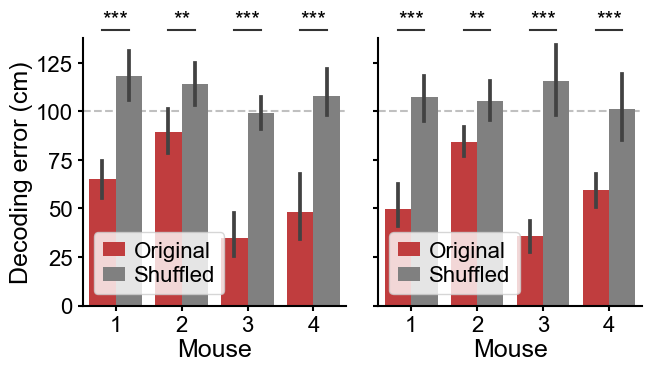

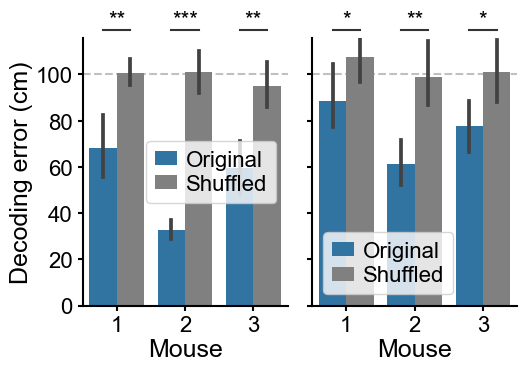

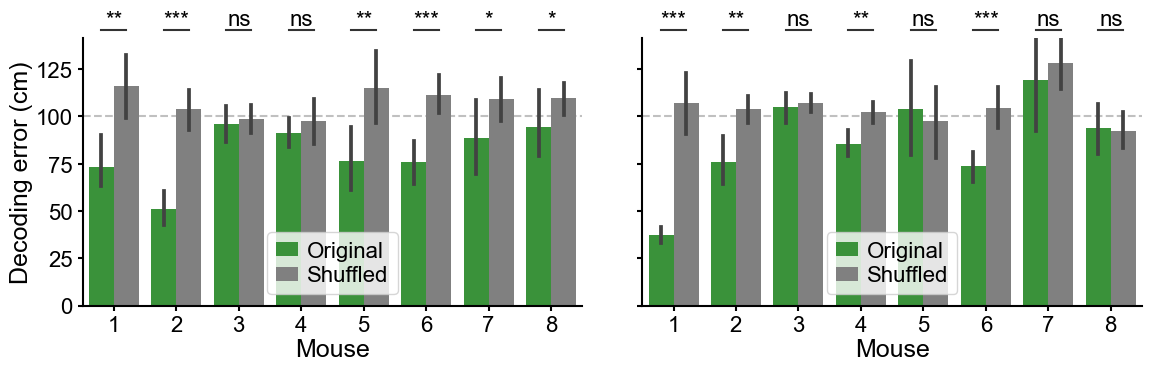

In [3]:
# %% Decoder accuracy for each mouse
def plot_error(excelfile, n_mice, palette):
    
    error_list_f = [[] for _ in range(n_mice)]
    error_list_n =[[] for _ in range(n_mice)]
    
    for m in range(n_mice):
        A = pd.read_excel(excelfile, sheet_name=str(m+1))
        error_list_f[m] = A[['F','F shuffle position']].to_numpy().T  # (2, n_samples)
        error_list_n[m] = A[['N','N shuffle position']].to_numpy().T  # 'N shuffle trial'
    
    fig, axs = plt.subplots(1,2,sharey=True,figsize=(1.8+n_mice*1.25,4))
    ut.compare_grouped(error_list_f, varnames=['Mouse','Data','Error'],
                       varvalues=[np.arange(1,n_mice+1),['Original','Shuffled'],None],
                       kind='bar', palette=palette, test='Mann-Whitney-ls', fig=fig, ax=axs[0])
    ut.compare_grouped(error_list_n, varnames=['Mouse','Data','Error'],
                       varvalues=[np.arange(1,n_mice+1),['Original','Shuffled'],None],
                       kind='bar', palette=palette, test='Mann-Whitney-ls', fig=fig, ax=axs[1])
    axs[0].set(ylabel='Decoding error (cm)')
    axs[1].set(ylabel='')
    for ax in axs:
        ax.axhline(100, c='silver', ls='--', zorder=-1)
    
    return fig, axs

for p, excelfile in enumerate(excelfiles):        
    fig, axs = plot_error(excelfile, n_mice_list[p], [colors[p],'gray'])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.12)
    # fig.savefig('Decode position '+exps[p]+'.svg')

--------Position decoder enriched.xlsx--------
Fam original vs shuffled, t-test paired (one-sided) p=0.005437
Nov original vs shuffled, t-test paired (one-sided) p=0.014161
Fam original vs Nov original, t-test paired (two-sided) p=0.744154
--------Position decoder dissimilar.xlsx--------
Fam original vs shuffled, t-test paired (one-sided) p=0.029454
Nov original vs shuffled, t-test paired (one-sided) p=0.020786
Fam original vs Nov original, t-test paired (two-sided) p=0.020141
--------Position decoder similar.xlsx--------
Fam original vs shuffled, t-test paired (one-sided) p=0.002075
Nov original vs shuffled, t-test paired (one-sided) p=0.035277
Fam original vs Nov original, t-test paired (two-sided) p=0.470685


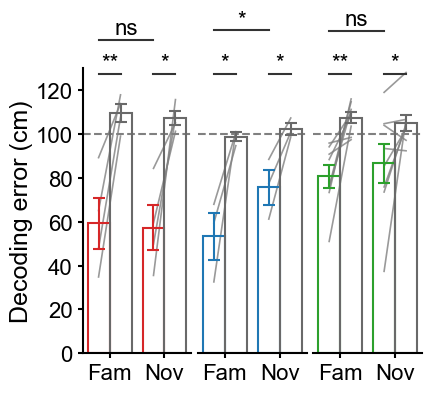

In [5]:
# %% Compare original and shuffled errors (average cross-validation)
def plot_summary(excelfile, n_mice, palette, ax):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    
    ## Draw a horizontal reference line
    ax.axhline(100, ls='--', c='gray', zorder=-2)
    
    error_list = [np.zeros((2,n_mice)) for _ in range(2)]  # [Fam (orig, shuf), Nov (orig, shuf)]
    for m in range(n_mice):
        A = pd.read_excel(excelfile, sheet_name=str(m+1))
        error_list[0][0,m] = np.mean(A['F'])
        error_list[0][1,m] = np.mean(A['F shuffle position'])
        error_list[1][0,m] = np.mean(A['N'])
        error_list[1][1,m] = np.mean(A['N shuffle position'])
    
    varnames = ['Context','Data','Error']
    varvalues = [['Fam','Nov'], ['Original','Shuffled'], None]
    ut.grouped_pair_lines(error_list, varnames=varnames, varvalues=varvalues, fig=fig, ax=ax, palette=palette, pairs=None)
    
    print('-'*8 + os.path.split(excelfile)[1] + '-'*8)
    df = ut.long_dataframe(error_list, varnames=varnames, varvalues=varvalues)
    pairs = [(('Fam','Original'),('Fam','Shuffled')),
             (('Nov','Original'),('Nov','Shuffled')),
             (('Fam','Original'),('Nov','Original'))]
    pvalues = [stats.ttest_rel(error_list[0][0], error_list[0][1], alternative='less')[1],
               stats.ttest_rel(error_list[1][0], error_list[1][1], alternative='less')[1],
               stats.ttest_rel(error_list[0][0], error_list[1][0], alternative='two-sided')[1]]
    print('Fam original vs shuffled, t-test paired (one-sided) p=%.6f' % pvalues[0])
    print('Nov original vs shuffled, t-test paired (one-sided) p=%.6f' % pvalues[1])
    print('Fam original vs Nov original, t-test paired (two-sided) p=%.6f' % pvalues[2])
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    annot = Annotator(ax, pairs, data=df, x='Context', y='Error', hue='Data', verbose=False)
    annot.configure(test=None, loc='outside', line_height=0., line_width=lwidth, pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
        
fig, axs = plt.subplots(1,len(exps),sharey=True,figsize=(4.6,4.2))
for p, excelfile in enumerate(excelfiles):
    df = plot_summary(excelfile, n_mice_list[p], palettes[p], ax=axs[p])
    axs[p].set(xticks=[0,1], xticklabels=['Fam','Nov'])
axs[0].set(ylabel='Decoding error (cm)', ylim=[0,130], yticks=np.arange(0,130,20))
for p in range(1,len(exps)):
    axs[p].axes.get_yaxis().set_visible(False)
    axs[p].spines['left'].set_visible(False)
fig.tight_layout()
fig.subplots_adjust(wspace=0.06)
# fig.savefig('Decoder error summary.svg')

Fam vs Nov, t-test paired (two-sided) p=0.744154
Fam vs Nov, t-test paired (two-sided) p=0.020141
Fam vs Nov, t-test paired (two-sided) p=0.470685


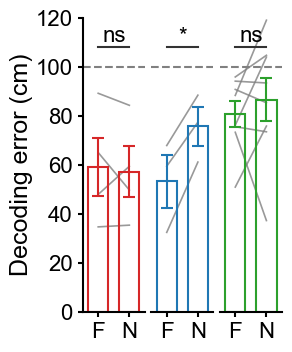

In [22]:
# %% Compare (original) Fam and Nov (average cross-validation)
def plot_comparison(excelfile, n_mice, color, ax):
    
    errors = np.zeros((n_mice,2))  # Fam/Nov
    for m in range(n_mice):
        A = pd.read_excel(excelfile, sheet_name=str(m+1))
        errors[m,0] = np.mean(A['F'])
        errors[m,1] = np.mean(A['N'])
    
    pvalue = stats.ttest_rel(errors[:,0], errors[:,1])[1]
    print('Fam vs Nov, t-test paired (two-sided) p=%.6f' % pvalue)
    
    ## Draw a horizontal reference line
    ax.axhline(100, ls='--', c='gray', zorder=-2)
    simple_pair_lines(
        errors, ax, category=['Fam','Nov'], colors=[color]*2, width=0.65, pvalue=[pvalue])
    
fig, axs = plt.subplots(1, len(exps), sharey=True, figsize=(3.2,3.8))
for p, excelfile in enumerate(excelfiles):
    plot_comparison(excelfile, n_mice_list[p], colors[p], axs[p])
    axs[p].set(xlim=[-0.5,1.5], xticks=[0,1], xticklabels=['F','N'])
axs[0].set(ylabel='Decoding error (cm)', ylim=[0,120])  # yticks=np.arange(0,130,20)
for p in range(1,len(exps)):
    axs[p].axes.get_yaxis().set_visible(False)
    axs[p].spines['left'].set_visible(False)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
# fig.savefig('Decoder error fam-nov.svg')

Original vs Shuffled, t-test paired (one-sided) p=0.000101
Original vs Shuffled, t-test paired (one-sided) p=0.001960
Original vs Shuffled, t-test paired (one-sided) p=0.000347
----------------
One-way ANOVA test: p=0.0148
Enriched vs Dissimilar: p=0.8344
Enriched vs Similar: p=0.0185
Dissimilar vs Similar: p=0.1334


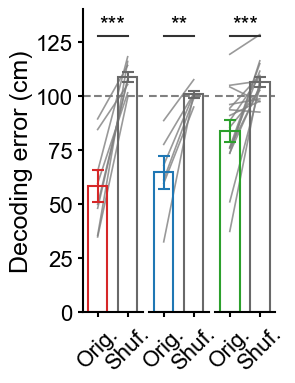

In [24]:
# %% Compare original and position-shuffled with pooled contexts (Fam and Nov)
def plot_pooled(excelfile, n_mice, palette, ax):
    
    errors = np.zeros((n_mice*2,2))  # Pooled Fam/Nov, Original/Shuffled
    for m in range(n_mice):
        A = pd.read_excel(excelfile, sheet_name=str(m+1))
        errors[2*m,0] = np.mean(A['F'])
        errors[2*m,1] = np.mean(A['F shuffle position'])
        errors[2*m+1,0] = np.mean(A['N'])
        errors[2*m+1,1] = np.mean(A['N shuffle position'])
    
    pvalue = stats.ttest_rel(errors[:,0], errors[:,1], alternative='less')[1]
    print('Original vs Shuffled, t-test paired (one-sided) p=%.6f' % pvalue)
    
    ## Draw a horizontal reference line
    ax.axhline(100, ls='--', c='gray', zorder=-2)
    simple_pair_lines(
        errors, ax, category=['Original','Shuffled'], colors=palette, width=0.65, pvalue=[pvalue])
    
    return errors

errors_list = []
fig, axs = plt.subplots(1, len(exps), sharey=True, figsize=(3.2,4.2))
for p, excelfile in enumerate(excelfiles):
    errors = plot_pooled(excelfile, n_mice_list[p], palettes[p], axs[p])
    errors_list.append(errors[:,0])  # Original
    axs[p].set(xlim=[-0.5,1.5], xticks=[0,1])
    axs[p].set_xticklabels(['Orig.','Shuf.'], rotation=45)
axs[0].set(ylabel='Decoding error (cm)', ylim=[0,140])  # yticks=np.arange(0,130,20)
for p in range(1,len(exps)):
    axs[p].axes.get_yaxis().set_visible(False)
    axs[p].spines['left'].set_visible(False)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
# fig.savefig('Decoder error pooled.svg')

## Multiple comparison
print('-'*16)
print('One-way ANOVA test: p=%.4f' % stats.f_oneway(*errors_list)[1])
post_hocs = stats.tukey_hsd(*errors_list)
for u, v in zip([0,0,1],[1,2,2]):
    print('%s vs %s: p=%.4f' % (exps[u], exps[v], post_hocs.pvalue[u,v]))

In [25]:
exps_list = []
for p, exp in enumerate(exps):
    exps_list.append([exp]*len(errors_list[p]))
df = pd.DataFrame({'Error': np.hstack(errors_list),
                   'Experiment': np.hstack(exps_list)})

test = pg.anova(data=df, dv='Error', between='Experiment')
print(test.round(4))

       Source  ddof1  ddof2       F   p-unc    np2
0  Experiment      2     27  4.9438  0.0148  0.268


In [26]:
test = pg.welch_anova(data=df, dv='Error', between='Experiment')
print(test.round(4))

       Source  ddof1    ddof2       F   p-unc    np2
0  Experiment      2  12.3702  4.6382  0.0314  0.268


In [27]:
post_hocs = pg.pairwise_tests(data=df, dv='Error', between='Experiment', parametric=True, padjust='bonf')
post_hocs.round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Dissimilar,Enriched,False,True,0.5873,11.3418,two-sided,0.5685,1.0000,bonf,0.503,0.2936
1,Experiment,Dissimilar,Similar,False,True,-2.0656,9.5609,two-sided,0.0670,0.2011,bonf,1.653,-0.9241
2,Experiment,Enriched,Similar,False,True,-2.8751,13.9510,two-sided,0.0123,0.0368,bonf,5.607,-1.2071


In [28]:
# When the groups are balanced and have equal variances, the optimal post-hoc test is the Tukey-HSD test
post_hocs = pg.pairwise_tukey(data=df, dv='Error', between='Experiment')
post_hocs.round(4)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Dissimilar,Enriched,64.5708,58.3312,6.2396,10.8485,0.5752,0.8344,0.2936
1,Dissimilar,Similar,64.5708,83.7312,-19.1604,9.6162,-1.9925,0.1334,-0.9241
2,Enriched,Similar,58.3312,83.7312,-25.4000,8.6982,-2.9202,0.0185,-1.2071


In [29]:
# If the groups have unequal variances, the Games-Howell test is more adequate
post_hocs = pg.pairwise_gameshowell(data=df, dv='Error', between='Experiment')
post_hocs.round(4)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Dissimilar,Enriched,64.5708,58.3312,6.2396,10.6250,0.5873,11.3418,0.8296,0.2936
1,Dissimilar,Similar,64.5708,83.7312,-19.1604,9.2761,-2.0656,9.5609,0.1493,-0.9241
2,Enriched,Similar,58.3312,83.7312,-25.4000,8.8344,-2.8751,13.9510,0.0309,-1.2071


Original vs Shuffled, t-test paired (one-sided) p=0.000771
Original vs Shuffled, t-test paired (one-sided) p=0.003004
Original vs Shuffled, t-test paired (one-sided) p=0.012994


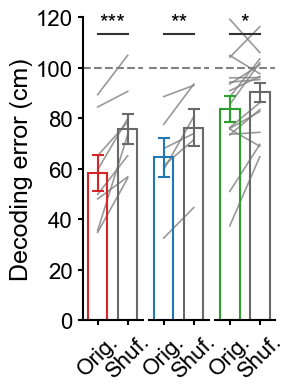

In [30]:
# %% Compare original and trial-shuffled errors (average cross-validation, pool context Fam/Nov)
def plot_shuffle_trial(excelfile, n_mice, palette, ax):

    errors = np.zeros((n_mice*2,2))  # Pooled Fam/Nov, Original/Shuffled trial
    for m in range(n_mice):
        A = pd.read_excel(excelfile, sheet_name=str(m+1))
        errors[2*m,0] = np.mean(A['F'])
        errors[2*m+1,0] = np.mean(A['N'])
        errors[2*m,1] = np.mean(A['F shuffle trial'])
        errors[2*m+1,1] = np.mean(A['N shuffle trial'])
    
    pvalue = stats.ttest_rel(errors[:,0], errors[:,1], alternative='less')[1]
    print('Original vs Shuffled, t-test paired (one-sided) p=%.6f' % pvalue)
    
    ## Draw a horizontal reference line
    ax.axhline(100, ls='--', c='gray', zorder=-2)
    simple_pair_lines(
        errors, ax, category=['Original','Shuffled'], colors=palette, width=0.65, pvalue=[pvalue])
    
    return errors

fig, axs = plt.subplots(1,3,sharey=True,figsize=(3.2,4.2))
for p, excelfile in enumerate(excelfiles):
    errors = plot_shuffle_trial(excelfile, n_mice_list[p], palettes[p], axs[p])
    axs[p].set(xlim=[-0.5,1.5], xticks=[0,1])
    axs[p].set_xticklabels(['Orig.','Shuf.'], rotation=45)
axs[0].set(ylabel='Decoding error (cm)', ylim=[0,120])
for p in range(1,len(exps)):
    axs[p].axes.get_yaxis().set_visible(False)
    axs[p].spines['left'].set_visible(False)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
# fig.savefig('Decoder error shuffle trial.svg')

Pooled 292 cells
--------------------------------
Slope: 0.446508
Intercept: 2.09326
R-squared: 0.045013
r-value: 0.212163
p-value: 0.000260668


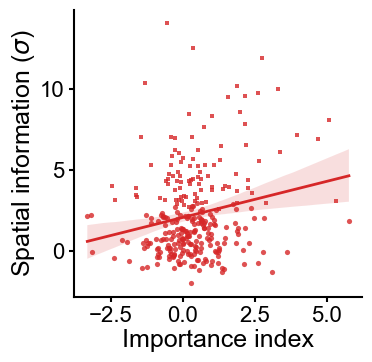

In [38]:
def plot_weight_correlation(excelfile, cellsprop, exp='Enriched', color='C0', min_rate=0, pval_thr=0.05):

    A = pd.read_excel(excelfile, sheet_name='Importance')
    cells = pd.read_excel(cellsprop, sheet_name=exp)
    rate = np.append(cells['Trate F'], cells['Trate N'])  # (2*ncell,)
    sub = (rate > min_rate)
    print('Pooled %d cells' % np.sum(sub))
    pvals = np.append(cells['SI pvalue F'], cells['SI pvalue N'])[sub]  # (2*ncell,)
    place_cells = (pvals <= pval_thr)
    
    ## Fam vs Nov importance index
    # fig, ax = plt.subplots(figsize=(4.5,4.2))
    # ax.scatter(A['Fam'], A['Nov'], s=14, c=color, alpha=0.8)
    # ax.set(xlabel='Importance Fam', ylabel='Importance Nov')  # xlim=[-3,3], ylim=[-3,3]
    # fig.tight_layout()
    
    ## Importance index vs SI
    x = np.append(A['Fam'], A['Nov'])[sub]
    y = np.append(cells['SI F'], cells['SI N'])[sub]
    df = pd.DataFrame({'Importance': x, 'SI': y})
    
    fig, ax = plt.subplots(figsize=(4,3.9))
    sns.regplot(data=df, x='Importance', y='SI', ax=ax, color=color, scatter=False, line_kws={'linewidth':2})
    ax.scatter(x[~place_cells], y[~place_cells], lw=0, s=14, c=color, alpha=0.8, marker='o', rasterized=False)
    ax.scatter(x[place_cells], y[place_cells], lw=0, s=12.5, c=color, alpha=0.8, marker='s', rasterized=False)
    ax.set(xlabel='Importance index', ylabel='Spatial information ($\sigma$)')
    fig.tight_layout()
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print('-'*32)
    print(f'Slope: {slope:.6g}')
    print(f'Intercept: {intercept:.6g}')
    print(f'R-squared: {r_value**2:.6g}')
    print(f'r-value: {r_value:.6g}')
    print(f'p-value: {p_value:.6g}')
    
    return fig, ax

p = 0
fig, ax = plot_weight_correlation(excelfiles[p], cellsprop, exp=exps[p], color=colors[p], min_rate=1/60, pval_thr=0.01)
fig.savefig('Importance index enriched.svg')

Pooled 155 cells
--------------------------------
Slope: 0.814108
Intercept: 2.25654
R-squared: 0.106157
r-value: 0.325817
p-value: 3.51846e-05


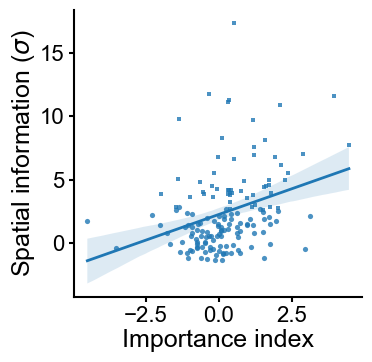

In [39]:
p = 1
fig, ax = plot_weight_correlation(excelfiles[p], cellsprop, exp=exps[p], color=colors[p], min_rate=1/60, pval_thr=0.01)
fig.savefig('Importance index dissimilar.svg')

Pooled 436 cells
--------------------------------
Slope: 0.253523
Intercept: 0.61547
R-squared: 0.047029
r-value: 0.216862
p-value: 4.88421e-06


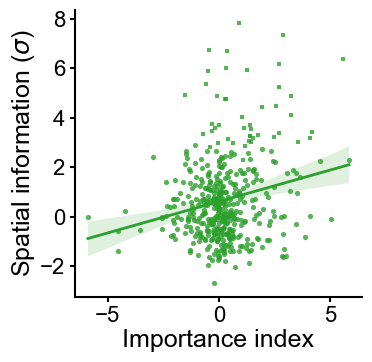

In [40]:
p = 2
fig, ax = plot_weight_correlation(excelfiles[p], cellsprop, exp=exps[p], color=colors[p], min_rate=1/60, pval_thr=0.01)
fig.savefig('Importance index similar.svg')